In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
from pathlib import Path
import copy

import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [4]:
dir_github = Path(r'D:\RH_local\github').resolve()

# dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6').resolve()
dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/').resolve()
# dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test').resolve()

## Directory with F.npy, stat.npy etc.
# dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve()
dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111/').resolve()
# dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/mouse_g8t/jobNum_0/suite2p/plane0').resolve()

# ## Path of iscell. Can be from neural net output (iscell_NN)
# # path_iscell = dir_analysisFiles / 'iscell_NN.npy'
# path_iscell = dir_analysisFiles / 'drawn_roi_classification_output.pkl'

## Directory to save outputs into
dir_save = dir_analysisFiles

In [5]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

# from basic_neural_processing_modules import ca2p_preprocessing, file_helpers
from bnpm import ca2p_preprocessing, file_helpers, path_helpers

In [6]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(dir_s2p)
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

iscell.npy not found in /media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111


In [7]:
# iscell = np.load(path_iscell)
path_iscell = path_helpers.find_paths(dir_outer=dir_analysisFiles, reMatch='roi_classification')[0]
iscell = file_helpers.pickle_load(path_iscell)['preds'][0].astype(np.bool8)

In [8]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

In [9]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F_toUse = np.delete(F_toUse, range(43000,50000), axis=1)
# Fneu_toUse = np.delete(Fneu_toUse, range(43000,50000), axis=1)

In [10]:
# channelOffset_correction = 0
percentile_baseline = 30
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_toUse,
                                                                 Fneu=Fneu_toUse,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 rolling_percentile_window=None,
                                                                 multicore_pref=True,
                                                                 verbose=True)

dFoF_params = {
    "channelOffset_correction": 0,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

Calculated dFoF. Total elapsed time: 7.97 seconds


In [11]:
# dFoF with reduced percentile for baseline
channelOffset_correction = 0
percentile_baseline = 30
neuropil_fraction = 0.7
win_rolling_percentile = 15*60*30

dFoF_rollingPtile, dF_rollingPtile, F_neuSub_rollingPtile, F_baseline_rollingPtile = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=win_rolling_percentile,
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

dFoF_params = {
    "channelOffset_correction": 0,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

100%|███████████████████████████████████████████| 36/36 [00:09<00:00,  3.88it/s]


Calculated dFoF. Total elapsed time: 11.82 seconds


<IPython.core.display.Javascript object>


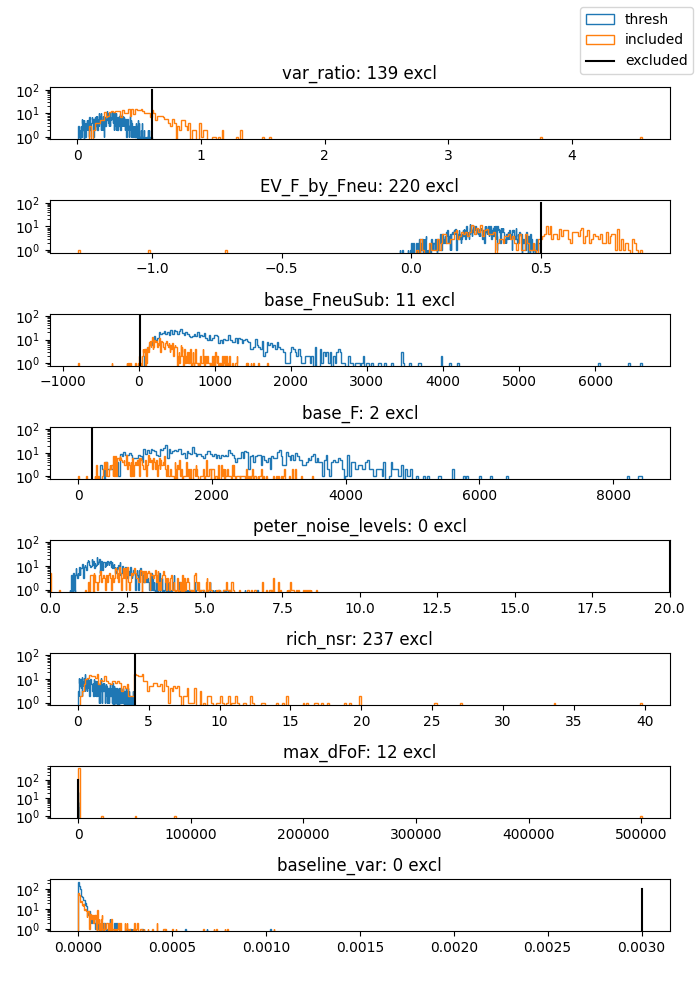

<IPython.core.display.Javascript object>


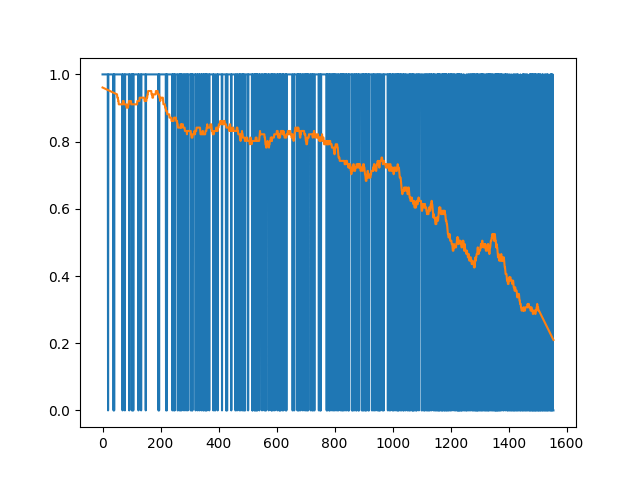

ROIs excluded: 460 / 1556
ROIs included: 1096 / 1556


In [28]:
%matplotlib notebook

thresh = {
    'var_ratio': 0.6,
    'EV_F_by_Fneu': 0.5,
    'base_FneuSub': 10,
    'base_F': 200,
    'peter_noise_levels': 20,
    'rich_nsr': 4,
    'max_dFoF': 15,
    'baseline_var': 0.003,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F_toUse,
    Fneu_toUse,
    dFoF_rollingPtile,
    dF_rollingPtile,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

<IPython.core.display.Javascript object>


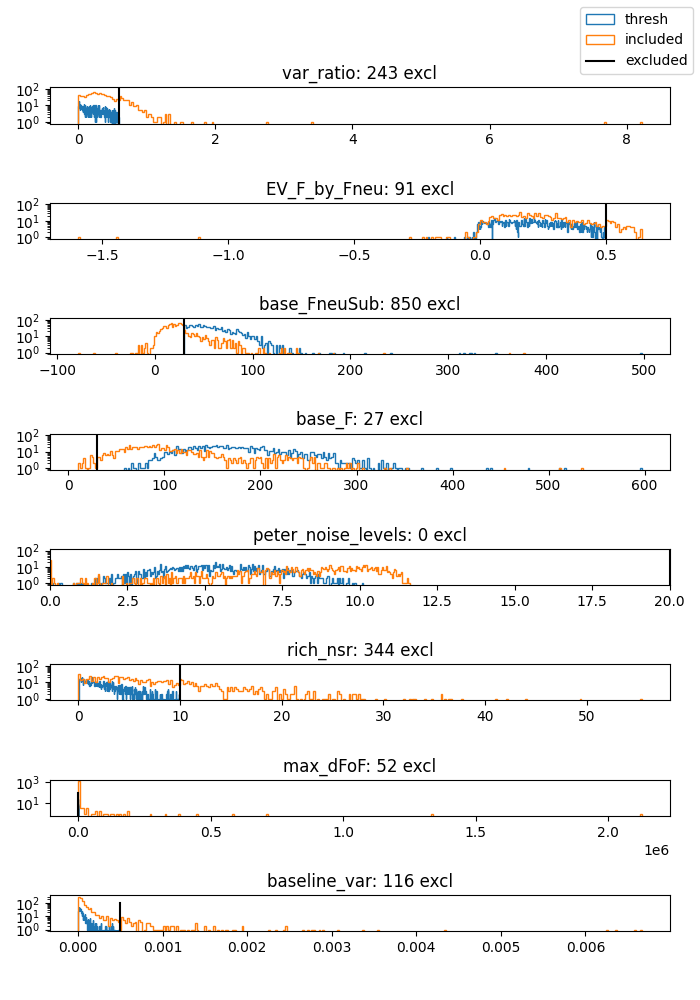

<IPython.core.display.Javascript object>


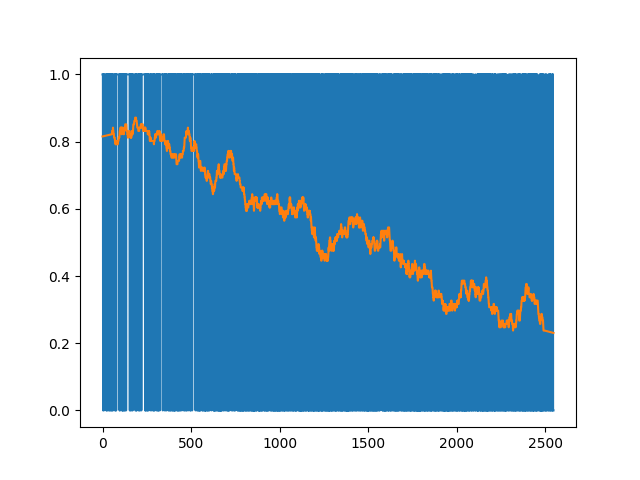

ROIs excluded: 1150 / 2547
ROIs included: 1397 / 2547


In [13]:
%matplotlib notebook

thresh = {
    'var_ratio': 0.6,
    'EV_F_by_Fneu': 0.5,
    'base_FneuSub': 30,
    'base_F': 30,
    'peter_noise_levels': 20,
    'rich_nsr': 10,
    'max_dFoF': 100,
    'baseline_var': 0.0005,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F_toUse,
    Fneu_toUse,
    dFoF_rollingPtile,
    dF_rollingPtile,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

<IPython.core.display.Javascript object>


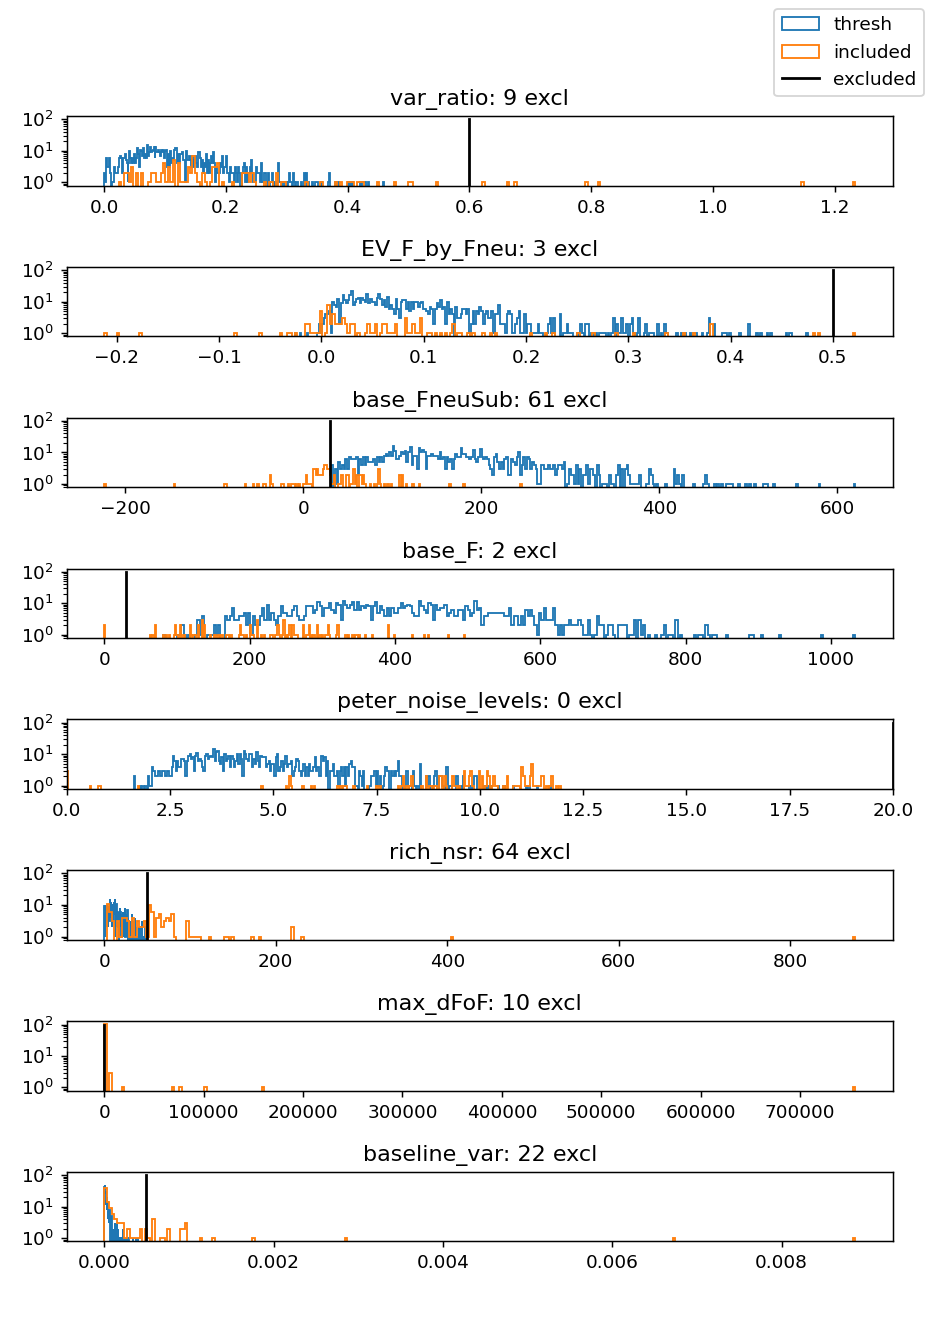

<IPython.core.display.Javascript object>


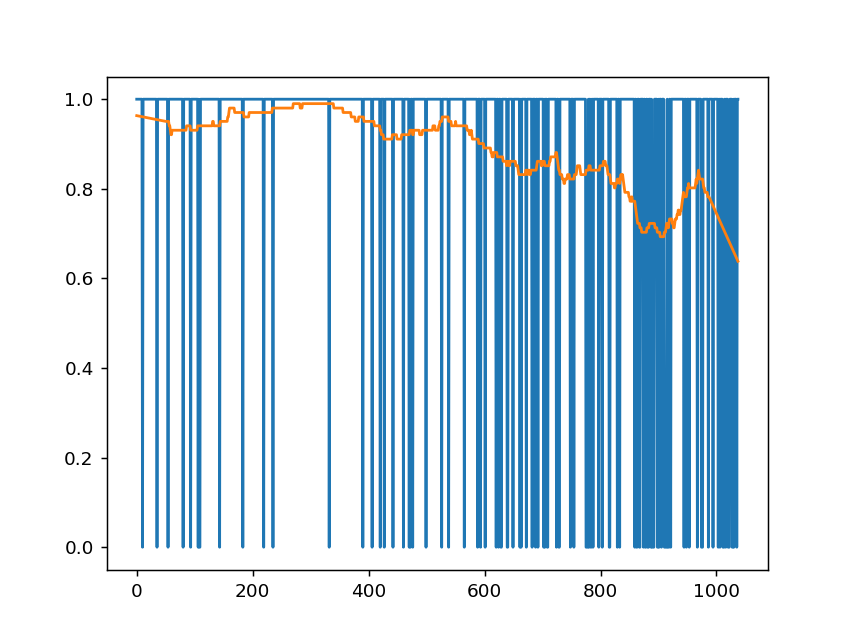

ROIs excluded: 115 / 1038
ROIs included: 923 / 1038


In [13]:
%matplotlib notebook

thresh = {
    'var_ratio': 0.6,
    'EV_F_by_Fneu': 0.5,
    'base_FneuSub': 30,
    'base_F': 30,
    'peter_noise_levels': 20,
    'rich_nsr': 50,
    'max_dFoF': 100,
    'baseline_var': 0.0005,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F_toUse,
    Fneu_toUse,
    dFoF_rollingPtile,
    dF_rollingPtile,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

In [14]:
iscell_new = copy.copy(iscell)
iscell_new[iscell_new] = iscell_tqm

In [15]:
file_helpers.pickle_save(
    obj={
        "tqm": tqm,
        "iscell_tqm": iscell_tqm,
        "dFoF_params": dFoF_params
    },
    path_save=dir_save / 'trace_quality.pkl'
)

np.save(
    file= dir_save / 'iscell_NN_tqm.npy',
    arr=iscell_new
)